In [35]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [36]:
import numpy as np
import pandas as pd
import warnings
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [37]:
pd.set_option("display.max_columns", None)
pd.set_option("display.float", "{:.2f}".format)
pd.set_option('display.max_rows', 20)
warnings.filterwarnings(action='ignore')

In [76]:
# 한글폰트적용
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

# Load dataset

In [38]:
retail = pd.read_csv('E-commerce.csv', parse_dates=['InvoiceDate'])

# 결측치 제거 및 거래 취소 데이터 제거 ('코호트 분석을 이용한 고객생애가치(CLV) 계산 프로젝트' 참고)
retail.dropna(subset = ['CustomerID'], inplace=True)
retail = retail[~retail['InvoiceNo'].str.contains('C')]

In [39]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


# RFM analysis

In [40]:
retail['TotalSum'] = retail['Quantity'] * retail['UnitPrice']

제품의 단위 가격과 해당 제품의 구매 수량을 이용하여 제품의 매출액을 나타내는 변수를 생성하였습니다.

In [41]:
print(
'The earliest date: {}\nThe latest date: {}'.format(min(retail['InvoiceDate']), max(retail['InvoiceDate'])))

The earliest date: 2010-12-01 08:26:00
The latest date: 2011-12-09 12:50:00


주어진 데이터세트는 2010년 12월 1일부터 2011년 12월 9일 까지 데이터가 수집 되었음을 확인하였습니다.

In [42]:
current_date = max(retail['InvoiceDate']) + dt.timedelta(days=1)

현 프로젝트를 데이터 수집이 완료된 다음 날 수행한다고 가정하고 분석 시점을 설정합니다.

In [43]:
rfm_tb = retail.groupby('CustomerID').agg({
    'InvoiceDate':lambda x: (current_date - max(x)).days,
    'InvoiceNo':'count',
    'TotalSum':'sum'
})

rfm_tb.rename(columns={'InvoiceDate':'Recency',
                      'InvoiceNo':'Frequency',
                      'TotalSum':'MonetaryValue'}, inplace=True)

rfm_tb

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.00,326,1,77183.60
12347.00,2,182,4310.00
12348.00,75,31,1797.24
12349.00,19,73,1757.55
12350.00,310,17,334.40
...,...,...,...
18280.00,278,10,180.60
18281.00,181,7,80.82
18282.00,8,12,178.05


주어진 데이터세트를 가공하여 RFM 테이블을 만들었습니다.

# K-means Clustering

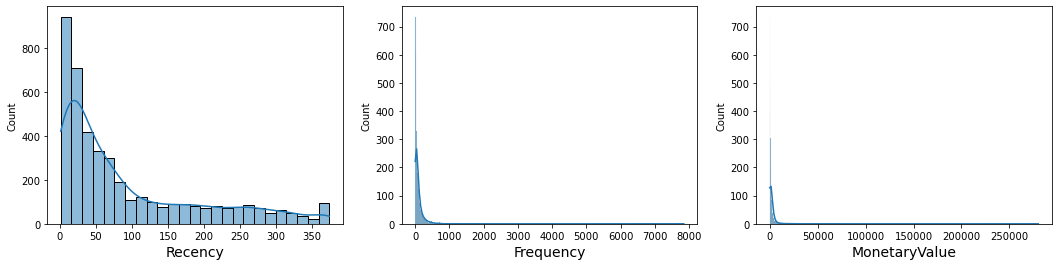

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ind, col in enumerate(rfm_tb.columns):
    _ = sns.histplot(x=col, data=rfm_tb, kde=True, ax = axes[ind])
    _ = axes[ind].set_xlabel(col, fontsize=14)

K평균 군집 분석을 실행 하기에 앞서 해당 변수들의 분포의 형태를 알아보았습니다. 세 변수 모두 오른쪽으로 긴 꼬리를 형태를 가진 왜곡이 심한 분포임을 알 수 있습니다.

In [45]:
rfm_tb.describe()

,Recency,Frequency,MonetaryValue
count,4339.00,4339.00,4339.00
mean,92.52,91.71,2053.79
std,100.01,228.79,8988.25
min,1.00,1.00,0.00
25%,18.00,17.00,307.24
50%,51.00,41.00,674.45
75%,142.00,100.00,1661.64
max,374.00,7847.00,280206.02


각 변수들의 기초 통계량을 확인 하였습니다.

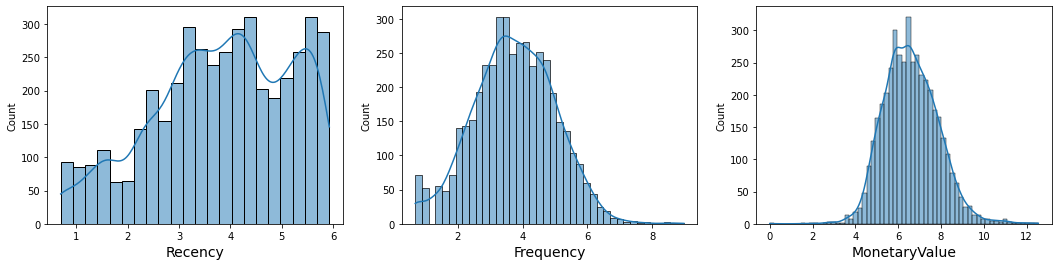

In [46]:
rfm_log = np.log(rfm_tb + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ind, col in enumerate(rfm_log.columns):
    _ = sns.histplot(x=col, data=rfm_log, kde=True, ax = axes[ind])
    _ = axes[ind].set_xlabel(col, fontsize=14)

모든 변수들을 로그 변환한 후에 다시 분포를 확인한 결과 정규분포에 가까워 졌음을 확인할 수 있습니다.

In [47]:
scaler = StandardScaler()
rfm_std = scaler.fit_transform(rfm_log)
rfm_std = pd.DataFrame(rfm_std, columns=rfm_tb.columns)

In [48]:
rfm_std.describe()

,Recency,Frequency,MonetaryValue
count,4339.00,4339.00,4339.00
mean,-0.00,-0.00,0.00
std,1.00,1.00,1.00
min,-2.34,-2.43,-5.23
25%,-0.66,-0.68,-0.68
50%,0.09,0.00,-0.06
75%,0.85,0.70,0.65
max,1.56,4.18,4.72


정규화 까지 마친 후 변수들의 기초통계량을 확인해 보니, 세 변수 모두 평균 0, 표준편차 1로 변환 되었음을 확인하였습니다.

KMeans(n_clusters=1, n_jobs=-1, random_state=802)

KMeans(n_clusters=2, n_jobs=-1, random_state=802)

KMeans(n_clusters=3, n_jobs=-1, random_state=802)

KMeans(n_clusters=4, n_jobs=-1, random_state=802)

KMeans(n_clusters=5, n_jobs=-1, random_state=802)

KMeans(n_clusters=6, n_jobs=-1, random_state=802)

KMeans(n_clusters=7, n_jobs=-1, random_state=802)

KMeans(n_jobs=-1, random_state=802)

KMeans(n_clusters=9, n_jobs=-1, random_state=802)

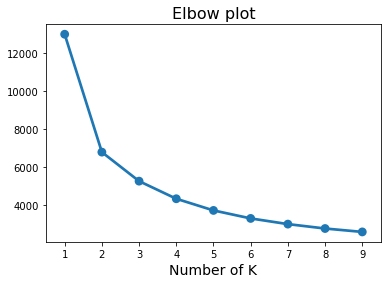

In [54]:
ssd = {}
for k in range(1, 10):
    km = KMeans(n_clusters=k, n_jobs=-1, random_state=802)
    km.fit(rfm_std)
    ssd[k] = km.inertia_
    
_ = sns.pointplot(x=list(ssd.keys()), y=list(ssd.values()))
_ = plt.xlabel('Number of K', fontsize=14)
_ = plt.title('Elbow plot', fontdict={'fontsize':16})

Elbow plot을 통해 적절한 군집의 수를 결정합니다.

In [56]:
# 군집 4개
km4 = KMeans(n_clusters=4, random_state=802)
km4.fit(rfm_std)

rfm_tb4 = rfm_tb.assign(Cluster = km4.labels_)

KMeans(n_clusters=4, random_state=802)

In [57]:
rfm_tb4.groupby('Cluster').mean()

,Recency,Frequency,MonetaryValue
Cluster,,,
0,19.89,38.75,612.06
1,96.50,80.18,1517.30
2,12.96,282.92,7042.57
3,185.12,14.95,298.18


K 평균 군집 분석을 통해 4개의 최적의 군집을 찾았습니다. 하지만 이 데이터세트는 로그 변환을 하기전 심하게 왜곡된 분포를 가지고 있었기 때문에 현재 가장 상위 군집인 `Cluster2`을 다시 세분화할 수 있을거라 판단하고 조금 더 알아보기로 합니다.

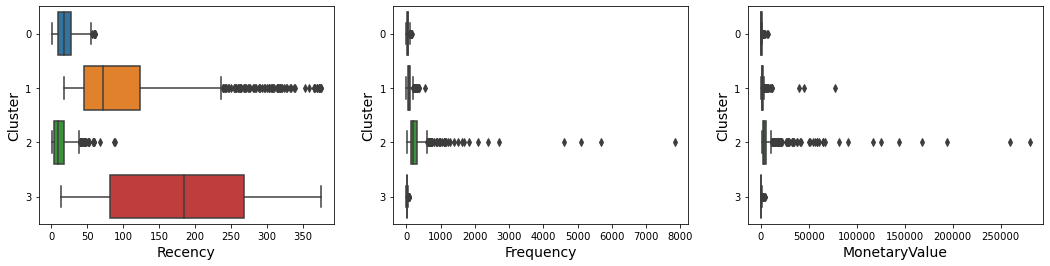

In [58]:
rfm_tb4['Cluster'] = rfm_tb4['Cluster'].astype('category')

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for ind, col in enumerate(['Recency', 'Frequency', 'MonetaryValue']):
    _ = sns.boxplot(x=col, y='Cluster', data=rfm_tb4, ax=axes[ind])
    _ = axes[ind].set_xlabel(col, fontsize=14)
    _ = axes[ind].set_ylabel('Cluster', fontsize=14)

각각의 군집을 각 변수 별로 박스플롯을 통해 분포의 형태를 알아보았습니다. 예상 했듯이 `Cluster2`의 분포를 보니 박스 플롯 상의 아웃라이어를 활용하여 최상위 고객을 나타내는 군집으로 더 세분화 할 수 있을거라 판단됩니다.

In [59]:
rfm_std4 = rfm_std.assign(Cluster=km4.labels_)

In [60]:
rfm_std4['Score'] = -rfm_std4['Recency']*(1/5) + rfm_std4['Frequency']*(2/5) + rfm_std4['MonetaryValue']*(2/5)
rfm_std4.sort_values('Score', ascending=False).head(10)

,Recency,Frequency,MonetaryValue,Cluster,Score
1880,-2.34,3.92,4.19,2,3.71
1690,-2.04,3.12,4.72,2,3.54
4011,-2.04,4.18,3.19,2,3.36
1290,-1.66,3.84,3.56,2,3.29
326,-2.34,3.75,3.04,2,3.19
2177,-2.34,3.23,3.51,2,3.16
4202,-2.34,1.86,4.66,2,3.08
562,-1.82,3.01,3.48,2,2.96
1334,-1.07,2.80,4.03,2,2.95
3772,-1.82,2.51,3.83,2,2.90


표준화된 데이터세트를 활용하여 `Recency`, `Frequency`, `MonetaryValue` 각 변수에 20%, 40%, 40%의 가중치를 주어 `Score`변수를 만들었습니다. `Score`가 높을 수록 고객 충성도와 지출금액이 높은 고객이라 할 수 있습니다.

In [63]:
top50 = rfm_std4.sort_values('Score', ascending=False).head(50).index
top50

Int64Index([1880, 1690, 4011, 1290,  326, 2177, 4202,  562, 1334, 3772, 1435,
            1662, 3729,   55,  997,  570, 3895, 1984, 1965, 1285, 1070,  691,
             558, 3177,  796, 2064, 1798, 1263, 1780,  100, 3943, 2584, 3684,
            1603, 3713,  445,   71, 2706,  223, 1054, 1059, 2313, 3824, 2703,
            2991, 3993,  273, 3956, 3897, 3694],
           dtype='int64')

In [64]:
rfm_tb4['Cluster'] = rfm_tb4['Cluster'].astype('int')
rfm_tb4.iloc[top50, 3] = 4

rfm_tb4 = rfm_tb4.reset_index()
rfm_tb4['Score'] = rfm_std4['Score']

`Score`가 가장 높은 최상위 50명의 고객을 새로운 군집(Cluster4)으로 분할 하였습니다.

In [68]:
rfm_tb4['Cluster'] = rfm_tb4['Cluster'].replace({4: '그룹1', 2:'그룹2', 1:'그룹3', 0:'그룹4', 3:'그룹5'})
rfm_tb4.drop('CustomerID', axis=1).groupby('Cluster').mean().sort_values('Score', ascending=False)

,Recency,Frequency,MonetaryValue,Score
Cluster,,,,
그룹1,4.70,1213.72,48078.29,2.46
그룹2,13.47,226.03,4534.27,1.17
그룹3,96.50,80.18,1517.30,0.22
그룹4,19.89,38.75,612.06,-0.07
그룹5,185.12,14.95,298.18,-0.93


세분화된 각 고객군 별 평균 `Recency`, `Frequency`, `MonetaryValue`, `Score`를 확인하였습니다. `Score`가 높을 수록 충성도와 지출액이 높은 고객군이라 볼 수 있을 것 같습니다. 하지만 그룹4 고객군은 그룹3 고객군에 비해 거래 빈도와 지출금액이 낮지만 비교적 최근까지 거래가 더 활발한 특징을 보입니다.